<a href="https://colab.research.google.com/github/Katefarber/LOAMS/blob/main/BaseCasePythonModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

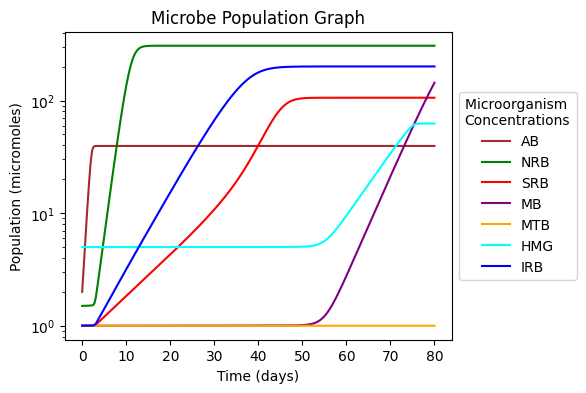

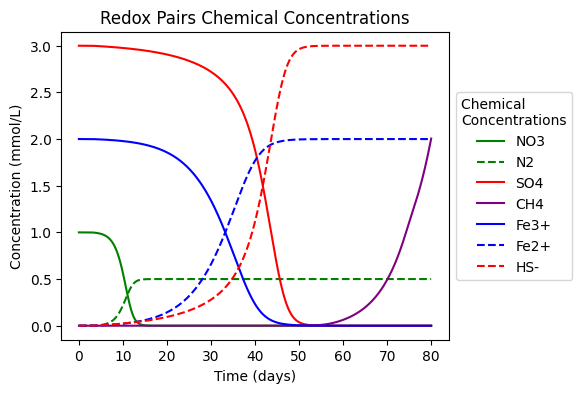

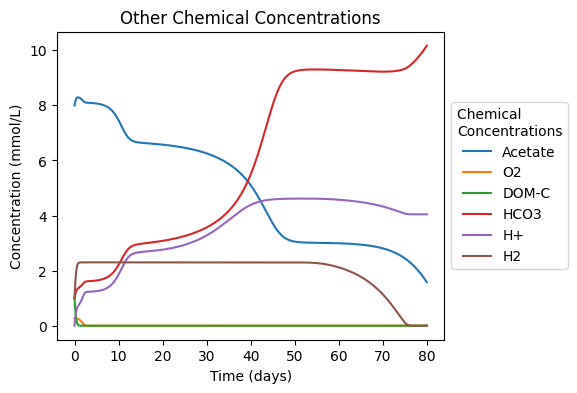

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[3], variables[4], variables[6], variables[11], variables[14], variables[17], variables[19]]  # Main chemical concentrations
other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18], variables[12]]  # Acetate, O2, DOM-C, HCO3, H+, H2


# Plotting microbes
plt.figure(figsize=(5, 4))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
microbe_colors = ["brown", "green", "red", "purple", "orange", "cyan", "blue"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting main chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["NO3", "N2", "SO4", "CH4", "Fe3+", "Fe2+", "HS-"]
chemical_colors = ["green", "green", "red", "purple", "blue", "blue", "red"]
chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "dashed", "dashed"]

for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
plt.title("Redox Pairs Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting other chemical concentrations
plt.figure(figsize=(5, 4))
other_chemical_names = ["Acetate", "O2", "DOM-C", "HCO3", "H+", "H2"]
other_chemical_colors = ["black", "blue", "grey", "cyan", "pink", "cyan"]
other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid"]

for i, chemical in enumerate(other_chemicals):
    plt.plot(t, chemical * 1e3, label=other_chemical_names[i])  # Convert to mmol/L
plt.title("Other Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()